 # Modeling OpenFDA FAERS data for Exploratory Analysis into Adverse Events

 ### Describing the code and abbreviations from OpenFDA data
 
 The dataset from OpenFDA comes in the form of 7 separate ASCII text file delimited by '$'. 

File Descriptions for ASCII Data Files:

  1. DEMOyyQq.TXT contains patient demographic and administrative information,
a single record for each event report.
  2. DRUGyyQq.TXT contains drug/biologic information for as many medications as
were reported for the event (1 or more per event).
  3. REACyyQq.TXT contains all "Medical Dictionary for Regulatory Activities"
(MedDRA) terms coded for the adverse event (1 or more). For more information
on MedDRA, please contact the MSSO Help Desk at mssohelp@meddra.org. The
website is www.meddra.org.
  4. OUTCyyQq.TXT contains patient outcomes for the event (0 or more).
  5. RPSRyyQq.TXT contains report sources for the event (0 or more).
  6. THERyyQq.TXT contains drug therapy start dates and end dates for the
reported drugs (0 or more per drug per event)



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import datetime as dt
%matplotlib inline

### Part I. Load 20yy Qq FAERS data and display preview

In [2]:
#### Define headers for dataframes

demo_head = ['Primary_ID', 'Case_ID', 'Case_Version', 'Initial/Follow-up', 'AE_Start_dt', 'Mfr_Receive_AE_dt',
             'FDA_init_Receive_Case_dt', 'FDA_Receive_Case_dt', 'Report_Type', 'Reg_Auth_Case_num', 'mfr_Unique_Report_ID', 
             'mfr_sender_code', 'Lit_Reference', 'Age', 'Age_Unit', 'Pt_Age_Group','SEX', 'E-submission(Y/N)', 'Pt_Weight','Pt_weight_Unit', 
             'Report_Send_dt', 'Report_Send_to_mfr_dt', 'Reporter_Occupation', 'Reporter_country', 'Event_country']

indi_head = ['Primary_ID', 'Case_ID', 'Drug_Seq', 'MedDRA_indi_term']

outc_head = ['Primary_ID', 'Case_ID', 'Pt_Outcome']

reac_head = ['Primary_ID', 'Case_ID', 'MedDRA_reac_term', 'ReAdmin_Event_Data']

rpsr_head = ['Primary_ID', 'Case_ID', 'RpSr_Code']

ther_head = ['Primary_ID', 'Case_ID', 'Drug_Seq', 'Start_Dt', 'End_Dt', 'Therapy_Duration', 'Ther_Units']

drug_head = ['Primary_ID', 'Case_ID', 'Drug_Seq', 'Reporter_role', 'Drug_Name', 'Active_Ingredient', 'Value_VBM', 
             'Drug_Name_Source', 'Route', 'Verbatim_Dose' 'Cum_Dose_to_Rxn', 'Cum_Dose_to_Rxn_Units', 'Dechall_Code',
            'Rechall_Code','Lot_Numb', 'Drug_Exp_dt', 'NDA_Numn', 'Dose_Amount', 'Dose_Unit', 'Dose_Form', 'Dose_Freq' ]


#### A. Load 20yy Qq FDA FAERS data from file

In [3]:
## NOTE: Variables for the FAERS datasets in this notebook were initially created based on the 2017Q1 files.
## As a result, the variable names past this cell will reflect the 2017Q1 version.
## To apply this code to a different year and quarter for FAERS data, only the filepath in this cell will be redirected,
## keeping all other variables constant.

demographic_txt = pd.read_csv('faers_ascii_2017q1/ascii/DEMO17Q1.txt', delimiter="$",header = 0, names = demo_head, 
                              low_memory = False,skipinitialspace = True, parse_dates = [6,7])
indication_txt = pd.read_csv('faers_ascii_2017q1/ascii/INDI17Q1.txt', delimiter="$", header = 0, names = indi_head, 
                             low_memory = False, skipinitialspace = True)
outcome_txt = pd.read_csv('faers_ascii_2017q1/ascii/OUTC17Q1.txt', delimiter="$", header = 0, names = outc_head, 
                          low_memory = False, skipinitialspace = True)
reaction_txt = pd.read_csv('faers_ascii_2017q1/ascii/REAC17Q1.txt', delimiter="$", header = 0, names = reac_head, 
                           low_memory = False, skipinitialspace = True)
rptsource_txt = pd.read_csv('faers_ascii_2017q1/ascii/RPSR17Q1.txt', delimiter="$", header = 0, names = rpsr_head, 
                            low_memory = False, skipinitialspace = True)
therapy_txt = pd.read_csv('faers_ascii_2017q1/ascii/THER17Q1.txt', delimiter="$", header = 0, names = ther_head, 
                          low_memory = False, skipinitialspace = True)
drug_txt = pd.read_csv('faers_ascii_2017q1/ascii/DRUG17Q1.txt', delimiter="$", header = 0, names = drug_head, 
                       low_memory = False, skipinitialspace = False)


#### B. Preview loaded FDA FAERS data

In [4]:
#### Demographics dataframe preview
demographic_txt.reset_index(level = 0)
demographic_txt.fillna(value = 'Unknown' )
demographic_txt = pd.DataFrame(demographic_txt)

demographic_txt[:5] ## Preview first 5 rows

,Primary_ID,Case_ID,Case_Version,Initial/Follow-up,AE_Start_dt,Mfr_Receive_AE_dt,FDA_init_Receive_Case_dt,FDA_Receive_Case_dt,Report_Type,Reg_Auth_Case_num,...,Pt_Age_Group,SEX,E-submission(Y/N),Pt_Weight,Pt_weight_Unit,Report_Send_dt,Report_Send_to_mfr_dt,Reporter_Occupation,Reporter_country,Event_country
0,100039237,10003923,7,F,2012.0,20170111.0,2014-03-12,2017-01-19,EXP,NaN,...,NaN,F,Y,62.13,KG,20170119.0,NaN,OT,US,US
1,1000588614,10005886,14,F,20140116.0,20170126.0,2014-03-13,2017-02-01,EXP,NaN,...,NaN,M,Y,90.00,KG,20170201.0,NaN,MD,IL,IL
2,100063033,10006303,3,F,NaN,20140304.0,2014-03-13,2017-02-27,EXP,NaN,...,A,F,Y,NaN,NaN,20170227.0,NaN,OT,CA,CA
3,100065923,10006592,3,F,20170211.0,20170214.0,2014-03-13,2017-02-17,EXP,NaN,...,E,F,Y,NaN,NaN,20170217.0,NaN,OT,US,US
4,100085064,10008506,4,F,20140402.0,20170214.0,2014-03-13,2017-02-20,EXP,NaN,...,A,F,Y,NaN,NaN,20170220.0,NaN,OT,US,US


In [5]:
### Indications dataframe
indication_txt.reset_index(level = 0)
indication_txt.fillna(value = 'Unknown' )
indication_txt = pd.DataFrame(indication_txt)

indication_txt[:5] ## Preview first 5 rows

,Primary_ID,Case_ID,Drug_Seq,MedDRA_indi_term
0,100039237,10003923,1,Myelofibrosis
1,100039237,10003923,2,Polycythaemia vera
2,100039237,10003923,3,Malignant melanoma
3,100039237,10003923,4,Product used for unknown indication
4,100039237,10003923,5,Product used for unknown indication


In [6]:
### Outcomes dataframe
outcome_txt.reset_index(inplace = True)
outcome_txt.fillna(value = 'Unknown' )
outcome_txt = pd.DataFrame(outcome_txt)

outcome_txt[:5] ## Preview first 5 rows

,index,Primary_ID,Case_ID,Pt_Outcome
0,0,100039237,10003923,OT
1,1,1000588614,10005886,HO
2,2,100063033,10006303,HO
3,3,100063033,10006303,OT
4,4,100065923,10006592,DE


In [7]:
### Reaction dataframe
reaction_txt.reset_index(inplace = True)
reaction_txt.fillna(value = 'Unknown')
reaction_txt = pd.DataFrame(reaction_txt)

reaction_txt[:5] ## Preview first 5 rows

,index,Primary_ID,Case_ID,MedDRA_reac_term,ReAdmin_Event_Data
0,0,100039237,10003923,Blindness,NaN
1,1,100039237,10003923,Constipation,NaN
2,2,100039237,10003923,Diarrhoea,NaN
3,3,100039237,10003923,Dizziness,NaN
4,4,100039237,10003923,Dry eye,NaN


In [8]:
### Report Sources dataframe
rptsource_txt.reset_index(inplace = True, drop = True)
rptsource_txt.fillna (value = 'Unknown')
rptsource_txt = pd.DataFrame(rptsource_txt)

rptsource_txt[:5] ## Preview first 5 rows

,Primary_ID,Case_ID,RpSr_Code
0,129685711,12968571,HP
1,130157522,13015752,HP
2,130815331,13081533,CSM
3,130815371,13081537,CSM
4,130838641,13083864,HP


In [9]:
### Therapy dataframe
therapy_txt.reset_index(inplace = True)
therapy_txt.fillna(value = 'Unknown')
therapy_txt = pd.DataFrame(therapy_txt)

therapy_txt[:5] ## Preview first 5 rows

,index,Primary_ID,Case_ID,Drug_Seq,Start_Dt,End_Dt,Therapy_Duration,Ther_Units
0,0,100039237,10003923,1,2011.0,NaN,NaN,NaN
1,1,100039237,10003923,2,20120106.0,NaN,NaN,NaN
2,2,100039237,10003923,3,20160825.0,NaN,NaN,NaN
3,3,1000588614,10005886,1,201306.0,NaN,NaN,NaN
4,4,100063033,10006303,1,201203.0,NaN,NaN,NaN


In [10]:
### Drug_dataframe
drug_txt.reset_index(level = 0)
drug_txt.fillna(value = 'Unknown' )
drug_txt = pd.DataFrame(drug_txt)

drug_txt[:5] ## Preview first 5 rows

,Primary_ID,Case_ID,Drug_Seq,Reporter_role,Drug_Name,Active_Ingredient,Value_VBM,Drug_Name_Source,Route,Verbatim_DoseCum_Dose_to_Rxn,Cum_Dose_to_Rxn_Units,Dechall_Code,Rechall_Code,Lot_Numb,Drug_Exp_dt,NDA_Numn,Dose_Amount,Dose_Unit,Dose_Form,Dose_Freq
0,100039237,10003923,1,PS,JAKAFI,RUXOLITINIB,1,Oral,"20 MG, BID",NaN,NaN,U,U,A81294Q,NaN,202192.0,20.0,MG,TABLET,BID
1,100039237,10003923,2,SS,JAKAFI,RUXOLITINIB,1,Oral,"7.5 MG, BID",NaN,NaN,U,U,A79945S,NaN,202192.0,7.5,MG,TABLET,BID
2,100039237,10003923,3,SS,JAKAFI,RUXOLITINIB,1,Oral,15 MG,NaN,NaN,U,U,NaN,NaN,202192.0,NaN,NaN,TABLET,NaN
3,100039237,10003923,4,C,ASPIRIN.,ASPIRIN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100039237,10003923,5,C,PLAVIX,CLOPIDOGREL BISULFATE,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TABLET,NaN


#### C. Create a dictionary for referencing country codes and patient outcomes in demographic_txt

In [11]:
## NOTE: For more information, visit https://www.accessdata.fda.gov/scripts/inspsearch/countrycodes.cfm 

### Define country code dictionary
Country_Dict = {'AD' : 'Andorra', 'AE' : 'United Arab Emirates', 'AF' : 'Afghanistan', 'AG' : 'Antigua & Barbuda', 
                'AI' : 'Anguilla', 'AL' : 'Albania', 'AM' : 'Armenia', 'AN' : 'Netherlands Antilles', 'AO' : 'Angola',
                'AR' : 'Argentina', 'AS' : 'American Samoa', 'AT' : 'Austria', 'AU' : 'Australia', 'AW' : 'Aruba',
                'AZ' : 'Azerbaijan', 'BA' : 'Bosnia-Hercegovina', 'BB' : 'Barbados', 'BD' : 'Bangladesh', 'BE' : 'Belgium', 
                'BF' : 'Burkina Faso', 'BG' : 'Bulgaria', 'BH' : 'Bahrain', 'BI' : 'Burundi', 'BJ' : 'Benin', 'BM' : 'Bermuda',
                'BN' : 'Brunei Darussalam', 'BO' : 'Bolivia', 'BR' : 'Brazil', 'BS' : 'Bahamas', 'BT' : 'Bhutan', 'BU' : 'Burma',
                'BW' : 'Botswana', 'BY' : 'Belarus', 'BZ' : 'Belize', 'CA' : 'Canada', 'CC' : 'Cocos Islands', 'CD' : 'Congo, Dem Rep of (Kinshasa)',
                'CF' : 'Central African Republic', 'CG' : 'Congo (Brazzaville)', 'CH' : 'Switzerland', 'CI' : 'Ivory Coast', 'CK' : 'Cook Islands',
                'CL' : 'Chile', 'CM' : 'Cameroon', 'CN' : 'China', 'CO' : 'Colombia', 'CR' : 'Costa Rica', 'CS' : 'Czechoslovakia (Do Not Use)',
                'CU' : 'Cuba', 'CV' : 'Cape Verde','CX' : 'Christmas Islands (Indian Ocn)', 'CY' : 'Cyprus', 'CZ' : 'Czech Republic','DE' : 'Germany',
                'DJ' : 'Djibouti','DK' : 'Denmark','DM' : 'Dominica','DO' : 'Dominican Republic','DZ' : 'Algeria','EC' : 'Ecuador',
                'EE' : 'Estonia','EG' : 'Egypt','EH' : 'Western Sahara','ER' : 'Eritrea','ES' : 'Spain','ET' : 'Ethiopia','FI' : 'Finland',
                'FJ' : 'Fiji','FK' : 'Falkland Islands','FM' : 'Micronesia', 'FM' : 'Federated State Of' ,'FO' : 'Faroe Islands','FR' : 'France',
                'GA' : 'Gabon','GB' : 'United Kingdom','GD' : 'Grenada','GE' : 'Georgia','GF' : 'French Guiana','GH' : 'Ghana',
                'GI' : 'Gibraltar','GL' : 'Greenland','GM' : 'Gambia, The','GN' : 'Guinea','GP' : 'Guadeloupe','GQ' : 'Equatorial Guinea',
                'GR' : 'Greece','GT' : 'Guatemala','GU' : 'Guam','GW' : 'Guinea-Bissau','GY' : 'Guyana','GZ' : 'Gaza Strip',
                'HK' : 'Hong Kong SAR','HM' : 'Heard & McDonald Islands','HN' : 'Honduras','HR' : 'Croatia','HT' : 'Haiti',
                'HU' : 'Hungary','ID' : 'Indonesia','IE' : 'Ireland','IL' : 'Israel','IN' : 'India','IO' : 'British Indian Ocean Territory',
                'IQ' : 'Iraq','IR' : 'Iran','IS' : 'Iceland','IT' : 'Italy','JM' : 'Jamaica','JO' : 'Jordan','JP' : 'Japan','KE' : 'Kenya',
                'KG' : 'Kyrgyzstan','KH' : 'Kampuchea','KI' : 'Kiribati','KM' : 'Comoros','KN' : 'Saint Christopher & Nevis',
                'KP' : 'Korea', 'KP' : 'Democratic Peoples Repu' ,'KR' : 'Korea, Republic Of (South)','KV' : 'Kosovo','KW' : 'Kuwait',
                'KY' : 'Cayman Islands','KZ' : 'Kazakhstan','LA' : 'Lao Peoples Democratic Repblc.','LB' : 'Lebanon','LC' : 'Saint Lucia',
                'LI' : 'Liechtenstein','LK' : 'Sri Lanka','LR' : 'Liberia','LS' : 'Lesotho','LT' : 'Lithuania','LU' : 'Luxembourg',
                'LV' : 'Latvia','LY' : 'Libya','MA' : 'Morocco','MC' : 'Monaco','MD' : 'Moldova','ME' : 'Montenegro','MG' : 'Madagascar',
                'MH' : 'Marshall Islands','MK' : 'Macedonia','ML' : 'Mali','MM' : 'Burma (Myanmar)','MN' : 'Mongolia','MO' : 'Macau SAR',
                'MP' : 'Northern Mariana Islands','MQ' : 'Martinique','MR' : 'Mauritania','MS' : 'Montserrat','MT' : 'Malta & Gozo',
                'MU' : 'Mauritius','MV' : 'Maldives','MW' : 'Malawi','MX' : 'Mexico','MY' : 'Malaysia','MZ' : 'Mozambique',
                'NA' : 'Namibia','NC' : 'New Caledonia','NE' : 'Niger','NF' : 'Norfolk Island','NG' : 'Nigeria','NI' : 'Nicaragua',
                'NL' : 'Netherlands','NO' : 'Norway','NP' : 'Nepal','NR' : 'Nauru','NT' : 'Neutral Zone (Iraq-Saudi Arab)',
                'NU' : 'Niue','NZ' : 'New Zealand','OM' : 'Oman','PA' : 'Panama','PE' : 'Peru','PF' : 'French Polynesia',
                'PG' : 'Papua New Guinea','PH' : 'Philippines','PK' : 'Pakistan','PL' : 'Poland','PM' : 'Saint Pierre & Miquelon',
                'PN' : 'Pitcairn Island','PR' : 'Puerto Rico','PS' : 'PALESTINIAN TERRITORY','PT' : 'Portugal','PW' : 'Palau',
                'PY' : 'Paraguay','QA' : 'Qatar','RE' : 'Reunion','RO' : 'Romania','RS' : 'Serbia','RU' : 'Russia','RW' : 'Rwanda',
                'SA' : 'Saudi Arabia','SB' : 'Solomon Islands','SC' : 'Seychelles','SD' : 'Sudan','SE' : 'Sweden','SG' : 'Singapore',
                'SH' : 'Saint Helena','SI' : 'Slovenia','SJ' : 'Svalbard & Jan Mayen Islands','SK' : 'Slovakia','SL' : 'Sierra Leone',
                'SM' : 'San Marino','SN' : 'Senegal','SO' : 'Somalia','SR' : 'Surinam','ST' : 'Sao Tome & Principe','SV' : 'El Salvador',
                'SY' : 'Syrian Arab Republic','SZ' : 'Swaziland','TC' : 'Turks & Caicos Island','TD' : 'Chad','TF' : 'French Southern Antarctic',
                'TG' : 'Togo','TH' : 'Thailand','TJ' : 'Tajikistan','TK' : 'Tokelau Islands','TL' : 'Timor Leste','TM' : 'Turkmenistan',
                'TN' : 'Tunisia','TO' : 'Tonga','TP' : 'East Timor','TR' : 'Turkey','TT' : 'Trinidad & Tobago','TV' : 'Tuvalu',
                'TW' : 'Taiwan','TZ' : 'Tanzania, United Republic Of','UA' : 'Ukraine','UG' : 'Uganda','UM' : 'United States Outlying Islands',
                'US' : 'United States','UY' : 'Uruguay','UZ' : 'Uzbekistan','VA' : 'Vatican City State','VC' : 'St. Vincent & The Grenadines',
                'VE' : 'Venezuela','VG' : 'British Virgin Islands','VI' : 'Virgin Islands Of The U. S.','VN' : 'Vietnam','VU' : 'Vanuatu',
                'WE' : 'West Bank','WF' : 'Wallis & Futuna Islands','WS' : 'Western Samoa','YD' : 'Yemen, Democratic (South)','YE' : 'Yemen',
                'YU' : 'Yugoslavia','ZA' : 'South Africa','ZM' : 'Zambia','ZW' : 'Zimbabwe'
}


### Convert Country codes from abbreviations to names
demographic_txt = demographic_txt.replace(Country_Dict)

### Define outcome code dictionary
Outcome_Dict = {'DE' : 'Death', 'LT' : 'Life-Threatening', 'HO' : 'Hospitalization', 'DS' : 'Disability', 'CA' : 'Congenital Anomaly',
                'RI' : 'Required Intervention', 'OT' : 'Other Serious Event'
}

### Convert outcome codes from abbreviations to names
outcome_txt = outcome_txt.replace(Outcome_Dict)

### Part II. Create a weekly histogram of FDA FAERS data 

#### A. Sort demographic_txt by date

In [12]:
### Sort demographic_txt by FDA_Recieve_Case_dt
demographic_txt_sort = demographic_txt.fillna(value = 'Unknown' ).sort_values('FDA_Receive_Case_dt')

### Pull out the Case_ID and FDA_Receive_Case_dt columns into separate dataframe
cases_2017q1 = demographic_txt_sort[['Case_ID', 'FDA_Receive_Case_dt']]

### Assign datetime format to FDA_Receive_Case_dt column
cases_2017q1 = pd.to_datetime(cases_2017q1['FDA_Receive_Case_dt'], format='%Y%m%d')

### Check types
cases_2017q1.dtypes


dtype('<M8[ns]')

In [13]:
### Segment the Quarter 1 Data (from demographic_txt) into Weekly intervals
## NOTE: Code is designed for Q1 FAERS data. This cell will need to be corrected for Q2, Q3, and Q4 FAERS data

## Week 1 
wk01 = pd.date_range(start = '2017-01-01', end = '2017-01-07', periods = None, freq = 'D' )

## Week 2 
wk02 = pd.date_range(start = '2017-01-08', end = '2017-01-14', periods = None, freq = 'D' )

## Week 3 
wk03 = pd.date_range(start = '2017-01-15', end = '2017-01-21', periods = None, freq = 'D' )

## Week 4 
wk04 = pd.date_range(start = '2017-01-22', end = '2017-01-28', periods = None, freq = 'D' )

## Week 5 
wk05 = pd.date_range(start = '2017-01-29', end = '2017-02-04', periods = None, freq = 'D' )

## Week 6 
wk06 = pd.date_range(start = '2017-02-05', end = '2017-02-11', periods = None, freq = 'D' )

## Week 7 
wk07 = pd.date_range(start = '2017-02-12', end = '2017-02-18', periods = None, freq = 'D' )

## Week 8 
wk08 = pd.date_range(start = '2017-02-19', end = '2017-02-25', periods = None, freq = 'D' )

## Week 9 
wk09 = pd.date_range(start = '2017-02-26', end = '2017-03-04', periods = None, freq = 'D' )

## Week 10 
wk10 = pd.date_range(start = '2017-03-05', end = '2017-03-11', periods = None, freq = 'D' )

## Week 11
wk11 = pd.date_range(start = '2017-03-12', end = '2017-03-18', periods = None, freq = 'D' )

## Week 12 
wk12 = pd.date_range(start = '2017-03-19', end = '2017-03-25', periods = None, freq = 'D' )

## Week 13 
wk13 = pd.date_range(start = '2017-03-26', end = '2017-03-31', periods = None, freq = 'D' )


#### B. Method for counting weekly intervals inside of cases_2017q1.dtypes using boolean values

In [14]:
### Split data into week segments and count cases for each week
## Week 1 
faers2017q1wk01 = cases_2017q1[cases_2017q1.isin(wk01)] ## Find if wkXX is in cases2017q1; if true, then boolean 1
faers2017q1wk1ct = len(faers2017q1wk01)                 ## Find the length of faers20yywkXX, i.e the number of cases in interval
                                                        ## Repeat for each week interval
## Week 2 
faers2017q1wk02 = cases_2017q1[cases_2017q1.isin(wk02)]
faers2017q1wk2ct = len(faers2017q1wk02)

## Week 3 
faers2017q1wk03 = cases_2017q1[cases_2017q1.isin(wk03)]
faers2017q1wk3ct = len(faers2017q1wk03)

## Week 4 
faers2017q1wk04 = cases_2017q1[cases_2017q1.isin(wk04)]
faers2017q1wk4ct = len(faers2017q1wk04)

## Week 5 
faers2017q1wk05 = cases_2017q1[cases_2017q1.isin(wk05)]
faers2017q1wk5ct = len(faers2017q1wk05)

## Week 6 
faers2017q1wk06 = cases_2017q1[cases_2017q1.isin(wk06)]
faers2017q1wk6ct = len(faers2017q1wk06)

## Week 7 
faers2017q1wk07 = cases_2017q1[cases_2017q1.isin(wk07)]
faers2017q1wk7ct = len(faers2017q1wk07)

## Week 8 
faers2017q1wk08 = cases_2017q1[cases_2017q1.isin(wk08)]
faers2017q1wk8ct = len(faers2017q1wk08)

## Week 9 
faers2017q1wk09 = cases_2017q1[cases_2017q1.isin(wk09)]
faers2017q1wk9ct = len(faers2017q1wk09)

## Week 10 
faers2017q1wk10 = cases_2017q1[cases_2017q1.isin(wk10)]
faers2017q1wk10ct = len(faers2017q1wk10)

## Week 11
faers2017q1wk11 = cases_2017q1[cases_2017q1.isin(wk11)]
faers2017q1wk11ct = len(faers2017q1wk11)

## Week 12 
faers2017q1wk12 = cases_2017q1[cases_2017q1.isin(wk12)]
faers2017q1wk12ct = len(faers2017q1wk12)

## Week 13 
faers2017q1wk13 = cases_2017q1[cases_2017q1.isin(wk13)]
faers2017q1wk13ct = len(faers2017q1wk13)

In [15]:
### Create a dataframe from faers2017qwk## for each week containing only Case_ID
## The purpose is to isolate Case_IDs for each week for use on drug_txt, indication_txt, and outcome_txt

## Week 1 
faers2017q1wk01caseid = pd.DataFrame(faers2017q1wk01.index, columns = ['Case_ID'] )

## Week 2
faers2017q1wk02caseid = pd.DataFrame(faers2017q1wk02.index, columns = ['Case_ID'] )

## Week 3 
faers2017q1wk03caseid = pd.DataFrame(faers2017q1wk03.index, columns = ['Case_ID'] )

## Week 4 
faers2017q1wk04caseid = pd.DataFrame(faers2017q1wk04.index, columns = ['Case_ID'] )

## Week 5 
faers2017q1wk05caseid = pd.DataFrame(faers2017q1wk05.index, columns = ['Case_ID'] )

## Week 6 
faers2017q1wk06caseid = pd.DataFrame(faers2017q1wk06.index, columns = ['Case_ID'] )

## Week 7 
faers2017q1wk07caseid = pd.DataFrame(faers2017q1wk07.index, columns = ['Case_ID'] )

## Week 8 
faers2017q1wk08caseid = pd.DataFrame(faers2017q1wk08.index, columns = ['Case_ID'] )

## Week 9 
faers2017q1wk09caseid = pd.DataFrame(faers2017q1wk09.index, columns = ['Case_ID'] )

## Week 10 
faers2017q1wk10caseid = pd.DataFrame(faers2017q1wk10.index, columns = ['Case_ID'] )

## Week 11
faers2017q1wk11caseid = pd.DataFrame(faers2017q1wk11.index, columns = ['Case_ID'] )

## Week 12 
faers2017q1wk12caseid = pd.DataFrame(faers2017q1wk12.index, columns = ['Case_ID'] )

## Week 13 
faers2017q1wk13caseid = pd.DataFrame(faers2017q1wk13.index, columns = ['Case_ID'] )


### Part III. Create a Histogram of the data from the FAERS 20yy Qq data.

In the following cells, we will create a very simple histogram of the data contained in faers_ascii_20yyQq. The purpose is to get a quick look at the difference in case counts across each week interval. The histogram should show: 
 * Figure 1 - "Histogram of All Cases In 2017q1": The y-axis should represent raw counts for cases in the dataset, with the x-axis representing aggregations of cases for every week interval. 
 * Note: The first quarter of the year runs from January 1st to March 31st, 2017, so a total of 13 weeks to be plotted on the x-axis. 
 * This histogram allows probing questions to be asked regarding world events that could have impacted the volume of FAERS cases submitted tot he FDA.

##### A. Raw case counts for FAERS data by week

In [16]:
### Create a frame for each FAERS week interval counts
faers2017q1val = (faers2017q1wk1ct, faers2017q1wk2ct, faers2017q1wk3ct, faers2017q1wk4ct, faers2017q1wk5ct, 
                  faers2017q1wk6ct, faers2017q1wk7ct, faers2017q1wk8ct, faers2017q1wk9ct, faers2017q1wk10ct, 
                  faers2017q1wk11ct, faers2017q1wk12ct, faers2017q1wk13ct)

### Assign an index for week # to faers2017q1val
faers2017q1vals = pd.Series(faers2017q1val, index = ['Week 1', 'Week 2', 'Week 3', 'Week 4', 'Week 5', 'Week 6', 
                                                    'Week 7', 'Week 8', 'Week 9', 'Week 10', 'Week 11', 'Week 12', 'Week 13'])

#
faers2017q1vals

Week 1     18633
Week 2     21640
Week 3     22042
Week 4     28497
Week 5     27458
Week 6     39109
Week 7     31247
Week 8     23165
Week 9     29137
Week 10    33036
Week 11    24933
Week 12    27795
Week 13    26513
dtype: int64

##### B. Setting ug the histogram characteristics

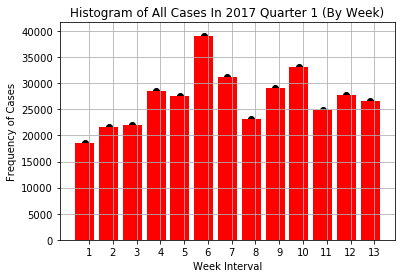

In [17]:
N = 13
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()

# add some text for labels, title and axes ticks
plt.title("Histogram of All Cases In 2017 Quarter 1 (By Week)")
plt.xlabel("Week Interval")
plt.ylabel("Frequency of Cases")

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'))

plt.grid(True)

plt.bar(range(len(faers2017q1vals)), faers2017q1vals, align='center', color = 'red')
plt.scatter(range(len(faers2017q1vals)), faers2017q1vals, color = 'black')

### Part IV. Stratifying the 2017 QI FAERS cases based on Demograpgics, Indications and Medications, and Outcomes of Interest

#### A1. Detailing parameters for Demographics
* Demographics of interest
 * Sex 
     * Male
     * Female
 * Country Reporting Adverse Event
     * Various (Focus should be on the United States (US) and Canada (CA)  
   
#### A2. Detailing parameters for Indications
* Indications of interest
 * Anxiety Disorders 
 * Bipolar illness
 * Personality disorders
 * Post-traumatic Stress Disorder
 * Major Depressive Disorder
 * Suicide/Suicidal Ideation 
 * Hypertension
 * Heart Disease
 * Irratable Bowel Syndrome 
 * Traumatic Brain Injury
 * Insomnia
 * Generalized Pain
 * Arthritis Pain
 * Schizophrenia
 * Substance Use Disorder
  
#### A3. Detailing parameters for Medications
* Medications of interest
 * Antidepressants:  
     * Bupropion
     * Citalopram 
     * Paroxetine 
     * Sertraline 
     * Duloxetine 
     * Fluoxetine
     * Mirtazepine 
 * Bipolar Medications:
     * Lithium/ Lithium Carbonate 
 * Anti-seizure:     
     * Lamotrigine
     * Valproate/Valproic Acid
 * Benzodiazepines
     * Alprazolam 
     * Diazepam 
     * Lorazepam 
     * Clonazepam 
     * Flurazepam
     * Quazepam
     * Triazolam
     * Estazolam
     * Temazepam
     * Oxazepam
     * Clorazepate
 * Narcotic Medications
     * Morphine 
     * Hydrocodone 
     * Oxycodone 
     * Codeine
     * Fentanyl 
     * Hydromorphone 
     * Oxymorphone
     * Trapentadol 
 * Misc:
     * Trazodone
     * Zolpidem 
     * Quetiapine 
     * Aripiprazole
     * Chlordiazepoxide
     * Meperidine 
     * Tramadol
     
#### A4. Detailing parameters for Outcomes
* Outcomes of interest
  * Patient Outcome codes:
     * Death
     * Life-Threatening
     * Hospitalization - Initial or Prolonged
     * Disability
     * Congenital Anomaly
     * Required Intervention to Prevent Permanent Impairment/Damage
     * Other Serious (Important Medical Event
  * Adverse Events tied to cases (see reaction_txt to query for adverse events as needed)
 

#### B. Querying indications of interest from 20yyQq FAERS data

In [18]:
### Set some global variables for hadling multiple medications for each case
seq = 99 #limit the sequence numbers associated with any single case  -- this changes the number of medications observed in each case to the first 5 reported


In [19]:
### Create several dataframes from indication_txt with only cases that contain indications of interest 

## columns to drop in each df
drop_col_indi = ['Primary_ID', 'MedDRA_indi_term']

# Anxiety Disorders
indi_anxiety = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('nxiety')])
indi_anxiety = indi_anxiety[indi_anxiety.Drug_Seq <= seq]
indi_anxiety.drop(drop_col_indi, axis = 1, inplace = True)
indi_anxiety['Anxiety Disorders'] = 1

# Bipolar Disorders
indi_bipolar = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('bipolar')])
indi_bipolar = indi_bipolar[indi_bipolar.Drug_Seq <= seq]
indi_bipolar.drop(drop_col_indi, axis = 1, inplace = True)
indi_bipolar['Bipolar Disorder'] = 1

# Personality Disorders
indi_personality = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('ersonality')])
indi_personality = indi_personality[indi_personality.Drug_Seq <= seq]
indi_personality.drop(drop_col_indi, axis = 1, inplace = True)
indi_personality['Borderline Personality Disorders'] = 1

# Post-traumatic stress disorder
indi_ptsd = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('traumatic stress')])
indi_ptsd = indi_ptsd[indi_ptsd.Drug_Seq <= seq]
indi_ptsd.drop(drop_col_indi, axis = 1, inplace = True)
indi_ptsd['Post-Traumatic Stress Disorder'] = 1

# Generalized depressive disorder
indi_mdd = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('epression')])
indi_mdd = indi_mdd[indi_mdd.Drug_Seq <= seq]
indi_mdd.drop(drop_col_indi, axis = 1, inplace = True)
indi_mdd['Generalized Depressive Disorder'] = 1

# Suicidal Ideation
indi_suicidal = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('uicid')])
indi_suicidal = indi_suicidal[indi_suicidal.Drug_Seq <= seq]
indi_suicidal.drop(drop_col_indi, axis = 1, inplace = True)
indi_suicidal['Suicidal Ideation'] = 1

# Generalized Hypertension
indi_htn = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('ypertension')])
indi_htn = indi_htn[indi_htn.Drug_Seq <= seq]
indi_htn.drop(drop_col_indi, axis = 1, inplace = True)
indi_htn['Generalized Hypertension'] = 1

# Heart Disease
indi_heartdisease = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('eart')])
indi_heartdisease = indi_heartdisease[indi_heartdisease.Drug_Seq <= seq]
indi_heartdisease.drop(drop_col_indi, axis = 1, inplace = True)
indi_heartdisease['Heart Disease'] = 1

# Irratable Bowel Syndrome
indi_ibs = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('bowel')])
indi_ibs = indi_ibs[indi_ibs.Drug_Seq <= seq]
indi_ibs.drop(drop_col_indi, axis = 1, inplace = True)
indi_ibs['Irratable Bowel Syndrome'] = 1

# Nerve Injury
indi_nerve = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('Nerve injury')])
indi_nerve = indi_nerve[indi_nerve.Drug_Seq <= seq]
indi_nerve.drop(drop_col_indi, axis = 1, inplace = True)
indi_nerve['Nerve Injury'] = 1

# Insomnia 
indi_insomnia = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('insomnia')])
indi_insomnia = indi_insomnia[indi_insomnia.Drug_Seq <= seq]
indi_insomnia.drop(drop_col_indi, axis = 1, inplace = True)
indi_insomnia['Insomnia'] = 1

# Arthritis Pain
indi_apain = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('rthrit')])
indi_apain = indi_apain[indi_apain.Drug_Seq <= seq]
indi_apain.drop(drop_col_indi, axis = 1, inplace = True)
indi_apain['Arthritis Pain'] = 1

# Generalized Pain
indi_gpain = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('Pain')])
indi_gpain = indi_gpain[indi_gpain.Drug_Seq <= seq]
indi_gpain.drop(drop_col_indi, axis = 1, inplace = True)
indi_gpain['Generalized Pain'] = 1

# Epilepsy
indi_epilep = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('pilep')])
indi_epilep = indi_epilep[indi_epilep.Drug_Seq <= seq]
indi_epilep.drop(drop_col_indi, axis = 1, inplace = True)
indi_epilep['Epilepsy'] = 1

# Seizures
indi_seiz = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('eizure')])
indi_seiz = indi_seiz[indi_seiz.Drug_Seq <= seq]
indi_seiz.drop(drop_col_indi, axis = 1, inplace = True)
indi_seiz['Seizures'] = 1

# Substance Use/Abuse Disorder (SUDS)
indi_suds = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('abuse')])
indi_suds = indi_suds[indi_suds.Drug_Seq <= seq]
indi_suds.drop(drop_col_indi, axis = 1, inplace = True)
indi_suds['Substance Use/Abuse Disorder'] = 1

# Schizophrenia
indi_schiz = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('Schiz')])
indi_schiz = indi_schiz[indi_schiz.Drug_Seq <= seq]
indi_schiz.drop(drop_col_indi, axis = 1, inplace = True)
indi_schiz['Schizophrenia'] = 1

# Drug/Substace Dependence
indi_depen = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('Drug dependence')])
indi_depen = indi_depen[indi_depen.Drug_Seq <= seq]
indi_depen.drop(drop_col_indi, axis = 1, inplace = True)
indi_depen['Drug/Substace Dependence'] = 1

# Other terms of relevance (works in progress) -- DO NOT USE
# Search for connections to the term 'childhood'
indi_childhood = pd.DataFrame(indication_txt[indication_txt.MedDRA_indi_term.str.contains('childhood')])
#NOTE on indi_childhood: only two results appear for 2017 Q1 Data; 
#consider looking to previous quarterly data for more samples -- come back to this later


#### C. Identifying medications of interest from 20yyQq FAERS data

##### C1. Find all patients in the first quarter 2017 data with any medication as mentioned above

In [20]:
### Create a dataframe from drug_txt with only cases that contain drugs mentioned in 

### drop columns for variables which will not be utilized
drop_col_drug = ['Value_VBM','Drug_Name_Source','Route','Verbatim_DoseCum_Dose_to_Rxn','Cum_Dose_to_Rxn_Units',
                 'Dechall_Code','Rechall_Code','Lot_Numb', 'Drug_Exp_dt', 'NDA_Numn','Dose_Amount' , 'Dose_Unit', 
                 'Dose_Form', 'Dose_Freq', 'Drug_Name', 'Reporter_role', 'Active_Ingredient', 'Primary_ID']

#do not drop drug seq for now

case_key = indication_txt[indication_txt.columns[0:3]] ### Create a base key for all Case_IDs

### drop columns for variables which will not be utilized
drop_col_drug = ['Value_VBM','Drug_Name_Source','Route','Verbatim_DoseCum_Dose_to_Rxn','Cum_Dose_to_Rxn_Units',
                 'Dechall_Code','Rechall_Code','Lot_Numb', 'Drug_Exp_dt', 'NDA_Numn','Dose_Amount' , 'Dose_Unit', 
                 'Dose_Form', 'Dose_Freq', 'Drug_Name', 'Reporter_role', 'Active_Ingredient', 'Primary_ID']

## Note: Do not drop drug seq for now-- we need this to specify how many sequential meds to include for each case

### Create a base key for all Case_IDs
case_key = indication_txt[indication_txt.columns[0:3]] 

##### C2. Create dataframes from drug_txt with only cases that contain medications of interest

In [21]:
## ---Benzodiazepines---
# Alprazolam
drug_Alprazolam = drug_txt[drug_txt.Active_Ingredient.str.contains("ALPRAZOLAM", na = False)]
drug_Alprazolam = drug_Alprazolam[drug_Alprazolam.Drug_Seq <= seq]
drug_Alprazolam.drop(drop_col_drug, axis = 1, inplace = True)
drug_Alprazolam['Alprazolam'] = 1
all_indi = pd.merge(case_key, drug_Alprazolam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Lorazepam
drug_Lorazepam = drug_txt[drug_txt.Active_Ingredient.str.contains("LORAZEPAM", na = False)]
drug_Lorazepam = drug_Lorazepam[drug_Lorazepam.Drug_Seq <= seq]
drug_Lorazepam.drop(drop_col_drug, axis = 1, inplace = True)
drug_Lorazepam['Lorazepam'] = 1
all_indi = pd.merge(all_indi, drug_Lorazepam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Clonazepam
drug_Clonazepam = drug_txt[drug_txt.Active_Ingredient.str.contains("CLONAZEPAM", na = False)]
drug_Clonazepam = drug_Clonazepam[drug_Clonazepam.Drug_Seq <= seq]
drug_Clonazepam.drop(drop_col_drug, axis = 1, inplace = True)
drug_Clonazepam['Clonazepam'] = 1
all_indi = pd.merge(all_indi, drug_Clonazepam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Diazepam
drug_Diazepam = drug_txt[drug_txt.Active_Ingredient.str.contains("DIAZEPAM", na = False)]
drug_Diazepam = drug_Diazepam[drug_Diazepam.Drug_Seq <= seq]
drug_Diazepam.drop(drop_col_drug, axis = 1, inplace = True)
drug_Diazepam['Diazepam'] = 1
all_indi = pd.merge(all_indi, drug_Diazepam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Flurazepam
drug_Flurazepam = drug_txt[drug_txt.Active_Ingredient.str.contains("FLURAZEPAM", na = False)]
drug_Flurazepam = drug_Flurazepam[drug_Flurazepam.Drug_Seq <= seq]
drug_Flurazepam.drop(drop_col_drug, axis = 1, inplace = True)
drug_Flurazepam['Flurazepam'] = 1
all_indi = pd.merge(all_indi, drug_Flurazepam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Quazepam
drug_Quazepam = drug_txt[drug_txt.Active_Ingredient.str.contains("QUAZEPAM", na = False)]
drug_Quazepam = drug_Quazepam[drug_Quazepam.Drug_Seq <= seq]
drug_Quazepam.drop(drop_col_drug, axis = 1, inplace = True)
drug_Quazepam['Quazepam'] = 1
all_indi = pd.merge(all_indi, drug_Quazepam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Triazolam
drug_Triazolam = drug_txt[drug_txt.Active_Ingredient.str.contains("TRIAZOLAM", na = False)]
drug_Triazolam = drug_Triazolam[drug_Triazolam.Drug_Seq <= seq]
drug_Triazolam.drop(drop_col_drug, axis = 1, inplace = True)
drug_Triazolam['Triazolam'] = 1
all_indi = pd.merge(all_indi, drug_Triazolam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Chlordiazepoxide
drug_Chlordiazepoxide = drug_txt[drug_txt.Active_Ingredient.str.contains("CHLORDIAZEPOXIDE", na = False)]
drug_Chlordiazepoxide = drug_Chlordiazepoxide[drug_Chlordiazepoxide.Drug_Seq <= seq]
drug_Chlordiazepoxide.drop(drop_col_drug, axis = 1, inplace = True)
drug_Chlordiazepoxide['Chlordiazepoxide'] = 1
all_indi = pd.merge(all_indi, drug_Chlordiazepoxide, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Estazolam
drug_Estazolam = drug_txt[drug_txt.Active_Ingredient.str.contains("ESTAZOLAM", na = False)]
drug_Estazolam = drug_Estazolam[drug_Estazolam.Drug_Seq <= seq]
drug_Estazolam.drop(drop_col_drug, axis = 1, inplace = True)
drug_Estazolam['Estazolam'] = 1
all_indi = pd.merge(all_indi, drug_Estazolam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Temazepam
drug_Temazepam = drug_txt[drug_txt.Active_Ingredient.str.contains("TEMAZEPAM", na = False)]
drug_Temazepam = drug_Temazepam[drug_Temazepam.Drug_Seq <= seq]
drug_Temazepam.drop(drop_col_drug, axis = 1, inplace = True)
drug_Temazepam['Temazepam'] = 1
all_indi = pd.merge(all_indi, drug_Temazepam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Oxazepam
drug_Oxazepam = drug_txt[drug_txt.Active_Ingredient.str.contains("OXAZEPAM", na = False)]
drug_Oxazepam = drug_Oxazepam[drug_Oxazepam.Drug_Seq <= seq]
drug_Oxazepam.drop(drop_col_drug, axis = 1, inplace = True)
drug_Oxazepam['Oxazepam'] = 1
all_indi = pd.merge(all_indi, drug_Oxazepam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Clorazepate
drug_Clorazepate = drug_txt[drug_txt.Active_Ingredient.str.contains("CLORAZEPATE", na = False)]
drug_Clorazepate = drug_Clorazepate[drug_Clorazepate.Drug_Seq <= seq]
drug_Clorazepate.drop(drop_col_drug, axis = 1, inplace = True)
drug_Clorazepate['Clorazepate'] = 1
all_indi = pd.merge(all_indi, drug_Clorazepate, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

## Generate total count for cases containing benzodiazepines
benzo_count = (len(drug_Alprazolam) + len(drug_Lorazepam) + len(drug_Clonazepam) + len(drug_Diazepam) 
               + len(drug_Flurazepam)+ len(drug_Quazepam)+ len(drug_Triazolam)+ len(drug_Chlordiazepoxide)
               + len(drug_Estazolam)+ len(drug_Temazepam)+ len(drug_Oxazepam)+ len(drug_Clorazepate))


In [22]:
### Generate dataframe of only Benzodiazepines
benzo_frame = indication_txt[indication_txt.columns[1:3]] ### Create a base key for all Case_IDs
benzo_frame = pd.merge(benzo_frame, drug_Alprazolam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
benzo_frame = pd.merge(benzo_frame, drug_Lorazepam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
benzo_frame = pd.merge(benzo_frame, drug_Clonazepam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
benzo_frame = pd.merge(benzo_frame, drug_Diazepam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
benzo_frame = pd.merge(benzo_frame, drug_Flurazepam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
benzo_frame = pd.merge(benzo_frame, drug_Quazepam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
benzo_frame = pd.merge(benzo_frame, drug_Triazolam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
benzo_frame = pd.merge(benzo_frame, drug_Chlordiazepoxide, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
benzo_frame = pd.merge(benzo_frame, drug_Estazolam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
benzo_frame = pd.merge(benzo_frame, drug_Temazepam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
benzo_frame = pd.merge(benzo_frame, drug_Oxazepam, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
benzo_frame = pd.merge(benzo_frame, drug_Clorazepate, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

### Drop all rows that have Nan in medication columns
benzo_frame = benzo_frame.dropna(thresh = 3) 

## note: There is no case in the dataframe that has more than one benzodiazepine (an interesting point to mention..)
 
### Sum the number of medications in a new dataframe
benzo_frame['Benzo_Tot'] = (benzo_frame.iloc[:, 2:14]).sum(axis = 1)

### Chech the size of benzo_frame
len(benzo_frame)

17653

In [23]:
## ---Narcotic Medications---
# Hydrocodone
drug_Hydrocodone = drug_txt[drug_txt.Active_Ingredient.str.contains("HYDROCODONE", na = False)]
drug_Hydrocodone = drug_Hydrocodone[drug_Hydrocodone.Drug_Seq <= seq]
drug_Hydrocodone.drop(drop_col_drug, axis = 1, inplace = True)
drug_Hydrocodone['Hydrocodone'] = 1
all_indi = pd.merge(all_indi, drug_Hydrocodone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Oxycodone
drug_Oxycodone = drug_txt[drug_txt.Active_Ingredient.str.contains("OXYCODONE", na = False)]
drug_Oxycodone = drug_Oxycodone[drug_Oxycodone.Drug_Seq <= seq]
drug_Oxycodone.drop(drop_col_drug, axis = 1, inplace = True)
drug_Oxycodone['Oxycodone'] = 1
all_indi = pd.merge(all_indi, drug_Oxycodone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Codeine
drug_Codeine = drug_txt[drug_txt.Active_Ingredient.str.contains("CODEINE", na = False)]
drug_Codeine = drug_Codeine[drug_Codeine.Drug_Seq <= seq]
drug_Codeine.drop(drop_col_drug, axis = 1, inplace = True)
drug_Codeine['Codeine'] = 1
all_indi = pd.merge(all_indi, drug_Codeine, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Morphine
drug_Morphine = drug_txt[drug_txt.Active_Ingredient.str.contains("MORPHINE", na = False)]
drug_Morphine = drug_Morphine[drug_Morphine.Drug_Seq <= seq]
drug_Morphine.drop(drop_col_drug, axis = 1, inplace = True)
drug_Morphine['Morphine'] = 1
all_indi = pd.merge(all_indi, drug_Morphine, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Fentanyl
drug_Fentanyl = drug_txt[drug_txt.Active_Ingredient.str.contains("FENTANYL", na = False)]
drug_Fentanyl = drug_Fentanyl[drug_Fentanyl.Drug_Seq <= seq]
drug_Fentanyl.drop(drop_col_drug, axis = 1, inplace = True)
drug_Fentanyl['Fentanyl'] = 1
all_indi = pd.merge(all_indi, drug_Fentanyl, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Hydromorphone
drug_Hydromorphone = drug_txt[drug_txt.Active_Ingredient.str.contains("HYDROMORPHONE", na = False)]
drug_Hydromorphone = drug_Hydromorphone[drug_Hydromorphone.Drug_Seq <= seq]
drug_Hydromorphone.drop(drop_col_drug, axis = 1, inplace = True)
drug_Hydromorphone['Hydromorphone'] = 1
all_indi = pd.merge(all_indi, drug_Hydromorphone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Meperidine
drug_Meperidine = drug_txt[drug_txt.Active_Ingredient.str.contains("MEPERIDINE", na = False)]
drug_Meperidine = drug_Meperidine[drug_Meperidine.Drug_Seq <= seq]
drug_Meperidine.drop(drop_col_drug, axis = 1, inplace = True)
drug_Meperidine['Meperidine'] = 1
all_indi = pd.merge(all_indi, drug_Meperidine, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Oxymorphone
drug_Oxymorphone = drug_txt[drug_txt.Active_Ingredient.str.contains("OXYMORPHONE", na = False)]
drug_Oxymorphone = drug_Oxymorphone[drug_Oxymorphone.Drug_Seq <= seq]
drug_Oxymorphone.drop(drop_col_drug, axis = 1, inplace = True)
drug_Oxymorphone['Oxymorphone'] = 1
all_indi = pd.merge(all_indi, drug_Oxymorphone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Trapentadol
drug_Trapentadol = drug_txt[drug_txt.Active_Ingredient.str.contains("TRAPENTADOL", na = False)]
drug_Trapentadol = drug_Trapentadol[drug_Trapentadol.Drug_Seq <= seq]
drug_Trapentadol.drop(drop_col_drug, axis = 1, inplace = True)
drug_Trapentadol['Trapentadol'] = 1
all_indi = pd.merge(all_indi, drug_Trapentadol, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Tramadol
drug_Tramadol = drug_txt[drug_txt.Active_Ingredient.str.contains("TRAMADOL", na = False)]
drug_Tramadol = drug_Tramadol[drug_Tramadol.Drug_Seq <= seq]
drug_Tramadol.drop(drop_col_drug, axis = 1, inplace = True)
drug_Tramadol['Tramadol'] = 1
all_indi = pd.merge(all_indi, drug_Tramadol, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

## Generate total count for cases containing narcotics
narcot_count = (len(drug_Hydrocodone) + len(drug_Oxycodone) + len(drug_Codeine) + len(drug_Morphine) 
                + len(drug_Fentanyl) + len(drug_Hydromorphone) + len(drug_Meperidine) + len(drug_Oxymorphone) 
                + len(drug_Trapentadol) + len(drug_Tramadol))


In [24]:
### Generate dataframe of only narcotics
narcot_frame = indication_txt[indication_txt.columns[1:3]] ### Create a base key for all Case_IDs
narcot_frame = pd.merge(narcot_frame, drug_Hydrocodone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
narcot_frame = pd.merge(narcot_frame, drug_Oxycodone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
narcot_frame = pd.merge(narcot_frame, drug_Codeine, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
narcot_frame = pd.merge(narcot_frame, drug_Morphine, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
narcot_frame = pd.merge(narcot_frame, drug_Fentanyl, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
narcot_frame = pd.merge(narcot_frame, drug_Hydromorphone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
narcot_frame = pd.merge(narcot_frame, drug_Meperidine, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
narcot_frame = pd.merge(narcot_frame, drug_Oxymorphone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
narcot_frame = pd.merge(narcot_frame, drug_Trapentadol, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
narcot_frame = pd.merge(narcot_frame, drug_Tramadol, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Drop all rows that have all NaN in medication columns
narcot_frame = narcot_frame.dropna(thresh = 3) ## Using the dropna(thresh = X) allows us to take advantage of the dataframes characteristic structure

### Sum the number of medications in a new dataframe
narcot_frame['narcot_Tot'] = (narcot_frame.iloc[:, 2:12]).sum(axis = 1)

## preview the first 5 rows
narcot_frame[:5]

,Case_ID,Drug_Seq,Hydrocodone,Oxycodone,Codeine,Morphine,Fentanyl,Hydromorphone,Meperidine,Oxymorphone,Trapentadol,Tramadol,narcot_Tot
41,10013378,7,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
56,10014432,30,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
126,10019135,15,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
147,10022215,11,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
148,10022215,12,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [25]:
## ---Narcotic Withdrawal Medications---
# Buprenorphine
drug_Buprenorphine = drug_txt[drug_txt.Active_Ingredient.str.contains("BUPRENORPHINE", na = False)]
drug_Buprenorphine = drug_Buprenorphine[drug_Buprenorphine.Drug_Seq <= seq]
drug_Buprenorphine.drop(drop_col_drug, axis = 1, inplace = True)
drug_Buprenorphine['Buprenorphine'] = 1
all_indi = pd.merge(all_indi, drug_Buprenorphine, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Methadone
drug_Methadone = drug_txt[drug_txt.Active_Ingredient.str.contains("METHADONE", na = False)]
drug_Methadone = drug_Methadone[drug_Methadone.Drug_Seq <= seq]
drug_Methadone.drop(drop_col_drug, axis = 1, inplace = True)
drug_Methadone['Methadone'] = 1
all_indi = pd.merge(all_indi, drug_Methadone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Naloxone
drug_Naloxone = drug_txt[drug_txt.Active_Ingredient.str.contains("NALOXONE", na = False)]
drug_Naloxone = drug_Naloxone[drug_Naloxone.Drug_Seq <= seq]
drug_Naloxone.drop(drop_col_drug, axis = 1, inplace = True)
drug_Naloxone['Naloxone'] = 1
all_indi = pd.merge(all_indi, drug_Naloxone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Naltrexone
drug_Naltrexone = drug_txt[drug_txt.Active_Ingredient.str.contains("NALTREXONE", na = False)]
drug_Naltrexone = drug_Naltrexone[drug_Naltrexone.Drug_Seq <= seq]
drug_Naltrexone.drop(drop_col_drug, axis = 1, inplace = True)
drug_Naltrexone['Naltrexone'] = 1
all_indi = pd.merge(all_indi, drug_Naltrexone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

## Generate total count for cases containing withdrawal medications
wthdrwl_count = (len(drug_Buprenorphine) + len(drug_Methadone) + len(drug_Naloxone) + len(drug_Naltrexone))

In [26]:
### Generate dataframe of only Narcotic Withdrawl Meds
wthdrwl_frame = indication_txt[indication_txt.columns[1:3]] ### Create a base key for all Case_IDs
wthdrwl_frame = pd.merge(wthdrwl_frame, drug_Buprenorphine, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
wthdrwl_frame = pd.merge(wthdrwl_frame, drug_Methadone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
wthdrwl_frame = pd.merge(wthdrwl_frame, drug_Naloxone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')
wthdrwl_frame = pd.merge(wthdrwl_frame, drug_Naltrexone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

### Drop all rows that have Nan in medication columns
wthdrwl_frame = wthdrwl_frame.dropna(thresh = 3) 

### Sum the number of medications in a new dataframe
wthdrwl_frameTot = pd.DataFrame()
wthdrwl_frame['wthdrwl_Tot'] = (wthdrwl_frame.iloc[:, 2:5]).sum(axis = 1)


In [27]:
### Checking for presence of narcotic withdrawal med + narcotic in same case
## Create a base key for all Case_IDs
narco_wthdrwl_frame = indication_txt[indication_txt.columns[1:3]]

### Merge withdrwl_frame with the narcotic frame
narco_wthdrwl_frame = pd.merge(wthdrwl_frame, narcot_frame, on = ['Case_ID'], how = 'outer')

### cleaning merge
narco_wthdrwl_frame = narco_wthdrwl_frame.drop(['Drug_Seq_x'], axis = 1)
narco_wthdrwl_frame = narco_wthdrwl_frame.drop(['Drug_Seq_y'], axis = 1)
narco_wthdrwl_frame = narco_wthdrwl_frame.drop(['wthdrwl_Tot'], axis = 1)
narco_wthdrwl_frame = narco_wthdrwl_frame.drop(['narcot_Tot'], axis = 1)


In [28]:
### define a totaling column named NC_tot
narco_wthdrwl_frame['NC_Tot'] = (narco_wthdrwl_frame.iloc[:, 1:16]).sum(axis = 1)
NCtot1 = narco_wthdrwl_frame[narco_wthdrwl_frame['NC_Tot'] ==2]

NCtot1[:5] ##-- because NC_Tot can equal 2, we can safely assume that some medications in our set are co-prescribed
           ##-- keep in mind that the threshold for these frames is still at 3

,Case_ID,Buprenorphine,Methadone,Naloxone,Naltrexone,Hydrocodone,Oxycodone,Codeine,Morphine,Fentanyl,Hydromorphone,Meperidine,Oxymorphone,Trapentadol,Tramadol,NC_Tot
0,10080580,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,10080580,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,10080580,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,10080580,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,10080580,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [29]:
## ---Selective Serotonin Reuptake Inhibitors (SSRIs)
# Paroxetine
drug_paroxetine = drug_txt[drug_txt.Active_Ingredient.str.contains("PAROXETINE", na = False)]
drug_paroxetine = drug_paroxetine[drug_paroxetine.Drug_Seq <= seq]
drug_paroxetine.drop(drop_col_drug, axis = 1, inplace = True)
drug_paroxetine['Paroxetine'] = 1
all_indi = pd.merge(all_indi, drug_paroxetine, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Sertraline
drug_sertraline = drug_txt[drug_txt.Active_Ingredient.str.contains("SERTRALINE", na = False)]
drug_sertraline = drug_sertraline[drug_sertraline.Drug_Seq <= seq]
drug_sertraline.drop(drop_col_drug, axis = 1, inplace = True)
drug_sertraline['Sertraline'] = 1
all_indi = pd.merge(all_indi, drug_sertraline, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Fluoxetine
drug_fluoxetine = drug_txt[drug_txt.Active_Ingredient.str.contains("FLUOXETINE", na = False)]
drug_fluoxetine = drug_fluoxetine[drug_fluoxetine.Drug_Seq <= seq]
drug_fluoxetine.drop(drop_col_drug, axis = 1, inplace = True)
drug_fluoxetine['Fluoxetine'] = 1
all_indi = pd.merge(all_indi, drug_fluoxetine, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Citalopram
drug_citalopram = drug_txt[drug_txt.Active_Ingredient.str.contains("CITALOPRAM", na = False)]
drug_citalopram = drug_citalopram[drug_citalopram.Drug_Seq <= seq]
drug_citalopram.drop(drop_col_drug, axis = 1, inplace = True)
drug_citalopram['Citalopram'] = 1
all_indi = pd.merge(all_indi, drug_citalopram, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

### Sum the number of medications in a new dataframe
ssriAD_count = (len(drug_paroxetine) + len(drug_sertraline) + len(drug_fluoxetine) + len(drug_citalopram))

In [30]:
## ---Norepinephine Dopamine Reuptake Inhibitors (NDRIs)
# Bupropion
drug_bupropion = drug_txt[drug_txt.Active_Ingredient.str.contains("BUPROPION", na = False)]
drug_bupropion = drug_bupropion[drug_bupropion.Drug_Seq <= seq]
drug_bupropion.drop(drop_col_drug, axis = 1, inplace = True)
drug_bupropion['Bupropion'] = 1
all_indi = pd.merge(all_indi, drug_bupropion, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

## ---Selective Norepinephrine Reuptake Inhibitors (SNRIs)
# Duloxetine
drug_duloxetine = drug_txt[drug_txt.Active_Ingredient.str.contains("DULOXETINE", na = False)]
drug_duloxetine = drug_duloxetine[drug_duloxetine.Drug_Seq <= seq]
drug_duloxetine.drop(drop_col_drug, axis = 1, inplace = True)
drug_duloxetine['Duloxetine'] = 1
all_indi = pd.merge(all_indi, drug_duloxetine, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

### Sum the number of NDRI medications in a new dataframe
ndri_snriAD_count = (len(drug_bupropion) + len(drug_duloxetine))

## ---Anti-psychotics
# Aripiprazole
drug_aripiprazole = drug_txt[drug_txt.Active_Ingredient.str.contains("ARIPIPRAZOLE", na = False)]
drug_aripiprazole = drug_aripiprazole[drug_aripiprazole.Drug_Seq <= seq]
drug_aripiprazole.drop(drop_col_drug, axis = 1, inplace = True)
drug_aripiprazole['Aripiprazole'] = 1
all_indi = pd.merge(all_indi, drug_aripiprazole, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Quetiapine
drug_quetiapine = drug_txt[drug_txt.Active_Ingredient.str.contains("QUETIAPINE", na = False)]
drug_quetiapine = drug_quetiapine[drug_quetiapine.Drug_Seq <= seq]
drug_quetiapine.drop(drop_col_drug, axis = 1, inplace = True)
drug_quetiapine['Quetiapine'] = 1
all_indi = pd.merge(all_indi, drug_quetiapine, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

### Sum the number of AS medications in a new dataframe
antipsy_count = (len(drug_aripiprazole) + len(drug_quetiapine))

## ---Monoamine Oxidase Inhibitors
# Mirtazepine
drug_mirtazepine = drug_txt[drug_txt.Active_Ingredient.str.contains("MIRTAZAPINE", na = False)]
drug_mirtazepine = drug_mirtazepine[drug_mirtazepine.Drug_Seq <= seq]
drug_mirtazepine.drop(drop_col_drug, axis = 1, inplace = True)
drug_mirtazepine['Mirtazapine'] = 1
all_indi = pd.merge(all_indi, drug_mirtazepine, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

### Sum the number of MOA medications in a new dataframe
mao_countAD = (len(drug_mirtazepine))

### Sum the number of antidepresant medications in a new dataframe
allAD_count = (ssriAD_count + mao_countAD + ndri_snriAD_count)

In [31]:
## ---Seizure Medications
# Valproic Acid
drug_vpa = drug_txt[drug_txt.Active_Ingredient.str.contains("VALPRO", na = False)]
drug_vpa = drug_vpa[drug_vpa.Drug_Seq <= seq]
drug_vpa.drop(drop_col_drug, axis = 1, inplace = True)
drug_vpa['Valproic Acid'] = 1
all_indi = pd.merge(all_indi, drug_vpa, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Lamotrigine
drug_lamotrigine = drug_txt[drug_txt.Active_Ingredient.str.contains("LAMOTRIGINE", na = False)]
drug_lamotrigine = drug_lamotrigine[drug_lamotrigine.Drug_Seq <= seq]
drug_lamotrigine.drop(drop_col_drug, axis = 1, inplace = True)
drug_lamotrigine['Lamotrigine'] = 1
all_indi = pd.merge(all_indi, drug_lamotrigine, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

### Sum the number of medications in a new dataframe
seize_count = (len(drug_vpa) + len(drug_lamotrigine))

## ---Insomnia Medications
# Trazodone
drug_trazodone = drug_txt[drug_txt.Active_Ingredient.str.contains("TRAZODONE", na = False)]
drug_trazodone = drug_trazodone[drug_trazodone.Drug_Seq <= seq]
drug_trazodone.drop(drop_col_drug, axis = 1, inplace = True)
drug_trazodone['Trazodone'] = 1
all_indi = pd.merge(all_indi, drug_trazodone, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

# Zolpidem
drug_zolpidem = drug_txt[drug_txt.Active_Ingredient.str.contains("ZOLPIDEM", na = False)]
drug_zolpidem = drug_zolpidem[drug_zolpidem.Drug_Seq <= seq]
drug_zolpidem.drop(drop_col_drug, axis = 1, inplace = True)
drug_zolpidem['Zolpidem'] = 1
all_indi = pd.merge(all_indi, drug_zolpidem, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

### Sum the number of medications in a new dataframe
insom_count = (len(drug_trazodone) + len(drug_zolpidem))

## ---Bipolar Medications
# Lithium
drug_lithium = drug_txt[drug_txt.Active_Ingredient.str.contains("LITHIUM", na = False)]
drug_lithium = drug_lithium[drug_lithium.Drug_Seq <= seq]
drug_lithium.drop(drop_col_drug, axis = 1, inplace = True)
drug_lithium['Lithium'] = 1
all_indi = pd.merge(all_indi, drug_lithium, on = ['Case_ID', 'Drug_Seq'], how = 'outer')

### Sum the number of medications in a new dataframe
bipo_count =  (len(drug_lithium))

##### C3. Create a pie chart for the Medication Class Counts 

In [32]:
### Aggregate counts of medication types for pie plot
all_med_counts = pd.DataFrame([bipo_count, insom_count, benzo_count, seize_count, 
                               mao_countAD, antipsy_count, ndri_snriAD_count, narcot_count ], 
                              index = ['Bipolar Medications', 'Insomnia Medications', 'Benzodiazepines', 'Seizure Medications', 
                               'MAO Medications', 'Antipsychotic Medications', 'SNRI/NDRI Medications', 'Narcotic Medications'], columns = ['Count'])

### Preview the counts for all med classes
all_med_counts

,Count
Bipolar Medications,843
Insomnia Medications,5893
Benzodiazepines,17644
Seizure Medications,4938
MAO Medications,1768
Antipsychotic Medications,5866
SNRI/NDRI Medications,12842
Narcotic Medications,30976


(-1.25, 1.25, -1.25, 1.25)

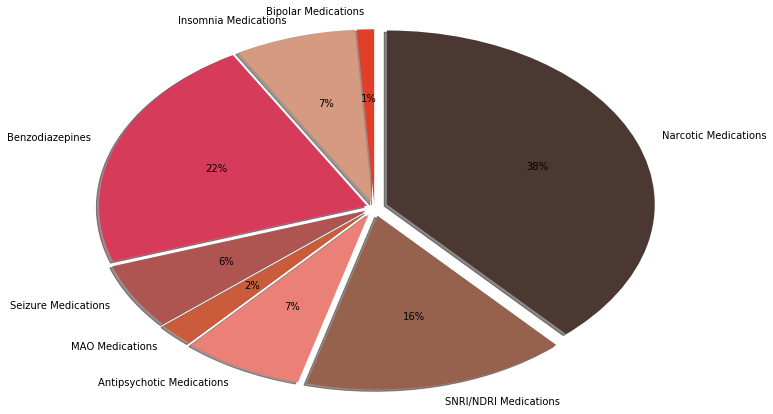

In [33]:
### Setting up the pie-chart

#colorwheel source: http://www.color-hex.com/color/e13f29
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B", 
          "#EB8076", "#96624E", "#4B3832", "#854442", "#FFF4E6", "#3C2F2F", "#BE9B7B"]

#pie_values
drug_all_index = all_med_counts.index

all_med_plot = plt.pie(
    # using data of total reports from each country
    all_med_counts.Count,
    # with the labels being index of rept_country_counts
    labels=drug_all_index,
    # with shadows
    shadow=True,
    # with colors defined above
    colors=colors,
    # with one slide exploded out
    explode=(0.05, 0.05, 0.06, 0.07, 0.08, 0.09, 0.095, 0.1),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.0f%%',
    radius = 2
    )
# View the plot drop above
plt.axis('off')
#plt.title('Distribution of Medication Types in 2017 Q1 FAERS Dataset')
# View the plot
#plt.legend(loc = "right", labels = labels)
#plt.tight_layout()
#plt.show()

In [34]:
### seed dataframe all_indi to new dataframe b to preserve all_indi
b = all_indi

#### C4. Combine medications dataframe (all_indi/b) with each indication dataframe

In [35]:
### Merge dataframes together on Case_ID and Drug_Seq

indi_frames = [indi_anxiety, indi_bipolar, indi_heartdisease, indi_htn, indi_ibs, 
               indi_insomnia, indi_mdd, indi_personality, indi_ptsd, indi_suicidal, 
               indi_apain, indi_gpain, indi_nerve, indi_epilep, indi_seiz, indi_seiz,
               indi_suds, indi_schiz, indi_depen]

b = pd.merge(b, indi_anxiety, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_bipolar, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_htn, how = 'left', on = ['Case_ID', 'Drug_Seq'])
#b = pd.merge(b, indi_ibs, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_insomnia, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_mdd, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_personality, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_ptsd, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_suicidal, how = 'left', on = ['Case_ID', 'Drug_Seq'])
#b = pd.merge(b, indi_heartdisease, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_apain, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_gpain, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_nerve, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_epilep, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_seiz, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_suds, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_schiz, how = 'left', on = ['Case_ID', 'Drug_Seq'])
b = pd.merge(b, indi_depen, how = 'left', on = ['Case_ID', 'Drug_Seq'])

### Check the length of b
len(b)

894807

In [36]:
### Send dataframe b to new dataframe d, and use an appropriate threshold for analysis of co-prescribed medications
d = b.dropna(thresh = 5) ##-- limit the dataframe to only include rows that have at least ([thresh value] minus [3]) or more coulmnns that are not non NaN 

### Check the length of d
len(d)

18662

In [37]:
###--preview first 5 rows of post-threshold d
d[:5] ##--if looks decent (not too large)

,Primary_ID,Case_ID,Drug_Seq,Alprazolam,Lorazepam,Clonazepam,Diazepam,Flurazepam,Quazepam,Triazolam,...,Post-Traumatic Stress Disorder,Suicidal Ideation,Arthritis Pain,Generalized Pain,Nerve Injury,Epilepsy,Seizures,Substance Use/Abuse Disorder,Schizophrenia,Drug/Substace Dependence
41,100133785.0,10013378,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
66,100144329.0,10014432,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
126,100191353.0,10019135,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
172,100242675.0,10024267,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
173,100242675.0,10024267,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
### save dataframe d to file
d.to_csv('faers_ascii_2017q1/ascii/result1.csv', index = False, header = True, sep = ',')

In [39]:
### Make a dataframe of all case_IDs in d for future references to our cases of interest
d_cases = d[[1]]

### check the length of d_cases (should be the same length as d..)
len(d_cases)

18662

In [40]:
### Isolate the Case_IDs that are in the DataFrame d above and send to a dataframe
cases_fin = pd.DataFrame(d['Case_ID'])

#--preview first 5 rows 
cases_fin[:5] #--preview first 5 rows -

,Case_ID
41,10013378
66,10014432
126,10019135
172,10024267
173,10024267


#### C5. Examining Demographic information from 2017 Q1 FAERS data

In [41]:
### Create a base key for all Case_IDs in demographic_txt
demo_key = pd.DataFrame(demographic_txt[['Case_ID', 'SEX', 'Event_country']])

### Merge cases that should be included (d_cases) with demo_key 
demo_key = pd.merge(demo_key, cases_fin, how = 'inner', on = 'Case_ID')

demo_key[:5] #--preview first 5 rows -

### Check the length of demo_key
#len(demo_key)

,Case_ID,SEX,Event_country
0,10013378,F,Canada
1,10014432,F,Canada
2,10019135,F,United States
3,10024267,F,United States
4,10024267,F,United States


In [42]:
len(demo_key)

18662

In [43]:
### Extract Case counts by country
rept_country_counts = pd.value_counts(demo_key.Event_country) #-- go with Event_country, not Report_countrty
rept_country_counts = pd.DataFrame(rept_country_counts)
rept_country_counts

### Merge demo_key with result from Part B
final_demo = pd.merge(d, demo_key, how = 'left', on = 'Case_ID', copy = False)
final_demo = final_demo.fillna('0')

### check the length of final_demo
len(final_demo)


37608

In [44]:
### send final_demo to csv
final_demo.to_csv('faers_ascii_2017q1/ascii/final_demo1.csv', index = False, header = True, sep = ',')

In [45]:
### ### Create a base key for all Case_IDs in reac_txt
reac_key = pd.DataFrame(reaction_txt[['Case_ID','MedDRA_reac_term']]) 
reac_key = reac_key.fillna('None Reported')

 #--preview first 5 rows 
reac_key[:5]

,Case_ID,MedDRA_reac_term
0,10003923,Blindness
1,10003923,Constipation
2,10003923,Diarrhoea
3,10003923,Dizziness
4,10003923,Dry eye


In [46]:
### Merge reac_key with result from Part C
final_reac = pd.merge(final_demo, reac_key, how = 'left', on = 'Case_ID')

In [47]:
### ### Create a base key for all Case_IDs in outc_txt
outc_key = pd.DataFrame(outcome_txt[['Case_ID','Pt_Outcome']])

outc_key[:5]

,Case_ID,Pt_Outcome
0,10003923,Other Serious Event
1,10005886,Hospitalization
2,10006303,Hospitalization
3,10006303,Other Serious Event
4,10006592,Death


In [48]:
### Merge outc_key with result from Part C
final_outc = pd.merge(final_reac, outc_key, how = 'left', on = 'Case_ID')

### Merge outc_key with result from final_demo (for analysis of demographic-outcome data)
final_demo_outc = pd.merge(final_demo, outc_key, how = 'left', on = 'Case_ID')

### send final_outc_demo to csv
final_demo_outc.to_csv('faers_ascii_2017q1/ascii/final_demo_outc_result1.csv', index = False, header = True, sep = ',')

In [49]:
### Drop Primary_ID -- no use anymore
final_outc = final_outc.drop(['Primary_ID'], axis = 1 )
final_outc = final_outc.replace({'' : 'None Reported'})

#--preview first 5 rows -
final_outc[:5]

,Case_ID,Drug_Seq,Alprazolam,Lorazepam,Clonazepam,Diazepam,Flurazepam,Quazepam,Triazolam,Chlordiazepoxide,...,Nerve Injury,Epilepsy,Seizures,Substance Use/Abuse Disorder,Schizophrenia,Drug/Substace Dependence,SEX,Event_country,MedDRA_reac_term,Pt_Outcome
0,10013378,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,F,Canada,Abscess intestinal,Other Serious Event
1,10013378,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,F,Canada,Erythema,Other Serious Event
2,10013378,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,F,Canada,Feeding disorder,Other Serious Event
3,10013378,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,F,Canada,Incorrect dose administered,Other Serious Event
4,10013378,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,F,Canada,Pain of skin,Other Serious Event


In [50]:
len(final_outc)

342420

In [51]:
### seed final reac to a new appropriately named DataFrame "final_FAERS2017Q1"
final_FAERS2017Q1 = final_outc

#create a temp variable to preserve final_FAERS2017Q1
test1 = final_FAERS2017Q1

In [52]:
### check the length of test1
len(test1)

### send test1 to csv
test1.to_csv('faers_ascii_2017q1/ascii/final_result1.csv', index = False, header = True, sep = ',')

##### D. Descriptive/Summary Statistics on Adverse Event Data

Calculate Frequency Distribution of Adverse Events in Dataset
The descriptive stats we are computing:
 * .describe() - count, mean, standard deviation, minimum value, 25%-tile, 50%-tile, 75%-tile, maximum values
 * .median() - median value of variables
 * .apply(mode, axis=None) - mode value of variables
 * .var() - variance
NOTE - If you reach an error, try using .reset_index() after each command.

In [53]:
###identify all AE reports in dataset
AEs_World = test1

## Count values for all Adverse Events from test1US
AEs_World_counts = pd.value_counts(AEs_World.MedDRA_reac_term)
AEs_World_counts = pd.DataFrame(AEs_World_counts)

## Determine quantile measure for AE counts that are in the q-tile of the data (we use top 1%-tile)
AEsq = 0.99

AEs_World_quant = AEs_World_counts['MedDRA_reac_term'].quantile(q = AEsq)

## apply quantile to AE count data
AEs_World_quant_totalcts = AEs_World_counts[AEs_World_counts['MedDRA_reac_term'] > AEs_World_quant]
#AEs_World_quant_counts

### Finding AE count by Patient Sex

##limit the AEs in final_FAERS2017Q1 by those stratified to the 99th %tile - only include SEX and AE Name
test1strat = test1[test1['MedDRA_reac_term'].isin(AEs_World_quant_totalcts.index)]
test1strat = pd.DataFrame(test1strat[['SEX', 'MedDRA_reac_term']])

##Split test1strat into Male and Female df
test1AEvalM = test1strat[test1strat['SEX']== 'M']
test1AEvalF = test1strat[test1strat['SEX']== 'F']

##count the frequencies of the male and female AE dataframe
test1AEvalM_count = pd.DataFrame(pd.value_counts(test1AEvalM.MedDRA_reac_term))
test1AEvalF_count = pd.DataFrame(pd.value_counts(test1AEvalF.MedDRA_reac_term))

## Combine the Total 99th %-tile AE counts, Male 99th %-tile AE counts, and Female 99th %-tile AE counts
All_AEs_World_quant_totalcts = pd.merge(test1AEvalM_count, test1AEvalF_count, 
                                     left_index = True, right_index = True, suffixes = ('_M', '_F'))

All_AEs_World_quant_totalcts = All_AEs_World_quant_totalcts.join(AEs_World_quant_totalcts)

## Preview the top 25 adverse events in the male and female cohort
All_AEs_World_quant_totalcts

#test1AEvalM_count
#test1AEvalF_count
#AEs_World_quant_totalcts

,MedDRA_reac_term_M,MedDRA_reac_term_F,MedDRA_reac_term
Insomnia,1950,4300,6430
Nausea,1809,4160,6139
Drug ineffective,1564,4014,5987
Dizziness,1667,3963,5933
Fatigue,1581,3957,5730
Anxiety,1715,3664,5587
Suicidal ideation,1165,3649,5022
Headache,1615,3058,4880
Vomiting,996,2907,3991
Agitation,1333,2758,4228


#### Plotting the top 99.9%-tile of Medication ADEs in 2017 Q1 FAERS Data

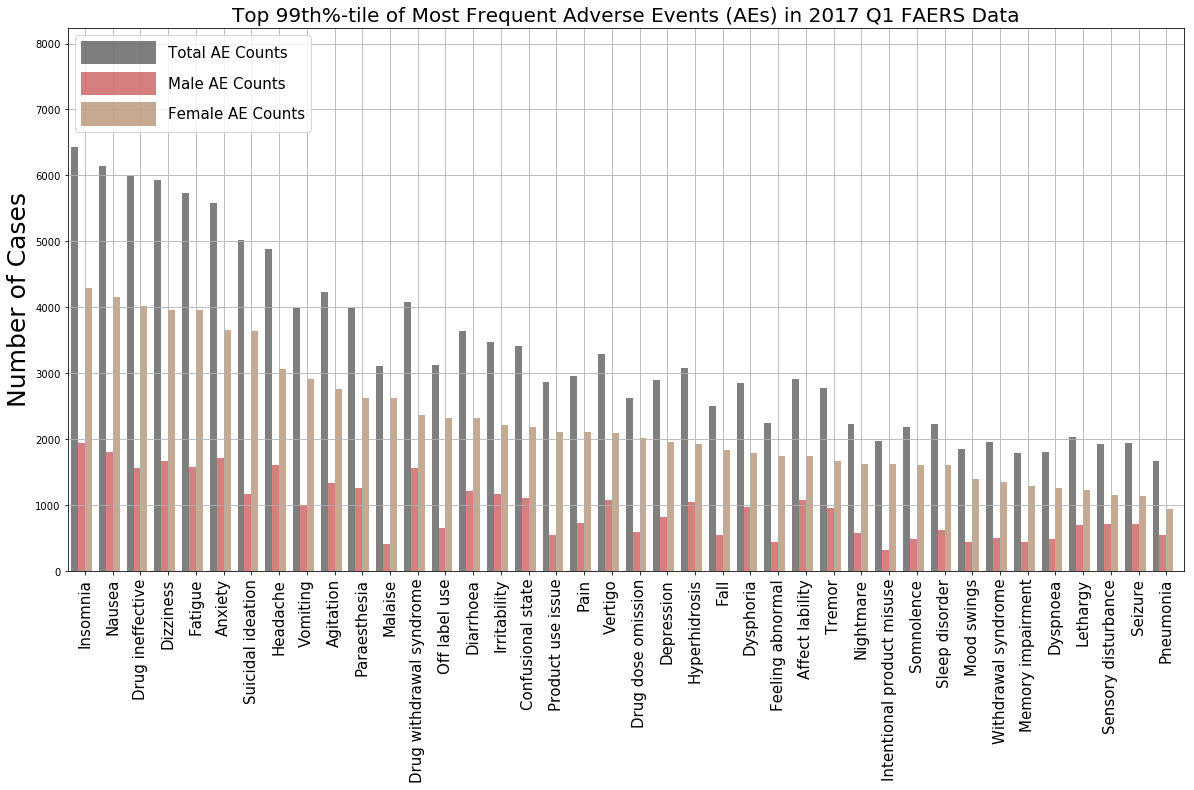

In [54]:
### Plot counts for top 90th%-tile of AEs in dataset across patient sex
# Setting up the positions and width for the bars
pos = list(range(len(All_AEs_World_quant_totalcts['MedDRA_reac_term'])))
width = 0.25

# Plotting the bars onto plot
fig, ax = plt.subplots(figsize=(20,10))

# Create a bar with Male+Female data,
# in position pos,
plt.bar(pos,
        #using All_AEs_US_quant_totalcts['MedDRA_reac_term'] data,
        All_AEs_World_quant_totalcts['MedDRA_reac_term'],
        # of width
        width,
        # with alpha 0.5
        alpha=0.5,
        # with color
        color="#000000",
        # with label the first value in first_name
        label='Total AE Counts')

# Create a bar with male AE data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos],
        #using test1AEvalM_count['MedDRA_reac_term_M'] data,
        All_AEs_World_quant_totalcts['MedDRA_reac_term_M'],
        # of width
        width,
        # with alpha 0.5
        alpha=0.5,
        # with color
        color="#ae0001",
        # with label the second value in first_name
        label= 'Male AE Counts')

# Create a bar with female data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos],
        #using test1AEvalF_count['MedDRA_reac_term_F'] data,
        All_AEs_World_quant_totalcts['MedDRA_reac_term_F'],
        # of width
        width,
        # with alpha 0.5
        alpha=0.5,
        # with color
        color="#8d5524",
        # with label the third value in first_name
        label='Female AE Counts')

# Set the y axis label
ax.set_ylabel('Number of Cases', fontsize = 25)

# Set the chart's title
ax.set_title('Top 99th%-tile of Most Frequent Adverse Events (AEs) in 2017 Q1 FAERS Data', fontsize = 20)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(All_AEs_World_quant_totalcts.index, rotation = 'vertical', fontsize = 15)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max((All_AEs_World_quant_totalcts['MedDRA_reac_term'] + 
                 All_AEs_World_quant_totalcts['MedDRA_reac_term_M'] + 
                 All_AEs_World_quant_totalcts['MedDRA_reac_term_F'])*.65)] )

# Adding the legend and showing the plot
plt.legend(['Total AE Counts', 'Male AE Counts', 'Female AE Counts'], loc='upper left', 
           fontsize = 15, handlelength = 5, handleheight = 2)
plt.grid()
plt.show()

#### Plotting the top 95%-tile of Medication ADEs in 2017 Q1 FAERS Data

In [55]:
###identify all AE reports coming from the United States
AEs_World1 = test1

## Count values for all Adverse Events from test1World1
AEs_World1_counts = pd.value_counts(AEs_World1.MedDRA_reac_term)
AEs_World1_counts = pd.DataFrame(AEs_World1_counts)

## Determine quantile measure for AE counts that are in the q-tile of the data (we World1e top 1.1%-tile)
AEsq1 = 0.98

AEs_World1_quant = AEs_World1_counts['MedDRA_reac_term'].quantile(q = AEsq1)

## apply quantile to AE count data
AEs_World1_quant_totalcts = AEs_World1_counts[AEs_World1_counts['MedDRA_reac_term'] > AEs_World1_quant]
#AEs_World1_quant_counts

### Finding AE count by Patient Sex

##limit the AEs in final_FAERS2017Q1 by those stratified to the 99.9th %tile - only include SEX and AE Name
test1strat = test1[test1['MedDRA_reac_term'].isin(AEs_World1_quant_totalcts.index)]
test1strat = pd.DataFrame(test1strat[['SEX', 'MedDRA_reac_term']])

##Split test1strat into Male and Female df
test1AEvalM = test1strat[test1strat['SEX']== 'M']
test1AEvalF = test1strat[test1strat['SEX']== 'F']

##count the frequencies of the male and female AE dataframe
test1AEvalM_count = pd.DataFrame(pd.value_counts(test1AEvalM.MedDRA_reac_term))
test1AEvalF_count = pd.DataFrame(pd.value_counts(test1AEvalF.MedDRA_reac_term))

## Combine the Total 99.9th %-tile AE counts, Male 99.9th%-tile AE counts, and Female 99.9th%-tile AE counts
All_AEs_World1_quant_totalcts = pd.merge(test1AEvalM_count, test1AEvalF_count, 
                                     left_index = True, right_index = True, suffixes = ('_M', '_F'))

All_AEs_World1_quant_totalcts = All_AEs_World1_quant_totalcts.join(AEs_World1_quant_totalcts)

## Preview the top 25 adverse events in the male and female cohort
All_AEs_World1_quant_totalcts

#test1AEvalM_count
#test1AEvalF_count
#AEs_World1_quant_totalcts

,MedDRA_reac_term_M,MedDRA_reac_term_F,MedDRA_reac_term
Insomnia,1950,4300,6430
Nausea,1809,4160,6139
Drug ineffective,1564,4014,5987
Dizziness,1667,3963,5933
Fatigue,1581,3957,5730
Anxiety,1715,3664,5587
Suicidal ideation,1165,3649,5022
Headache,1615,3058,4880
Vomiting,996,2907,3991
Agitation,1333,2758,4228


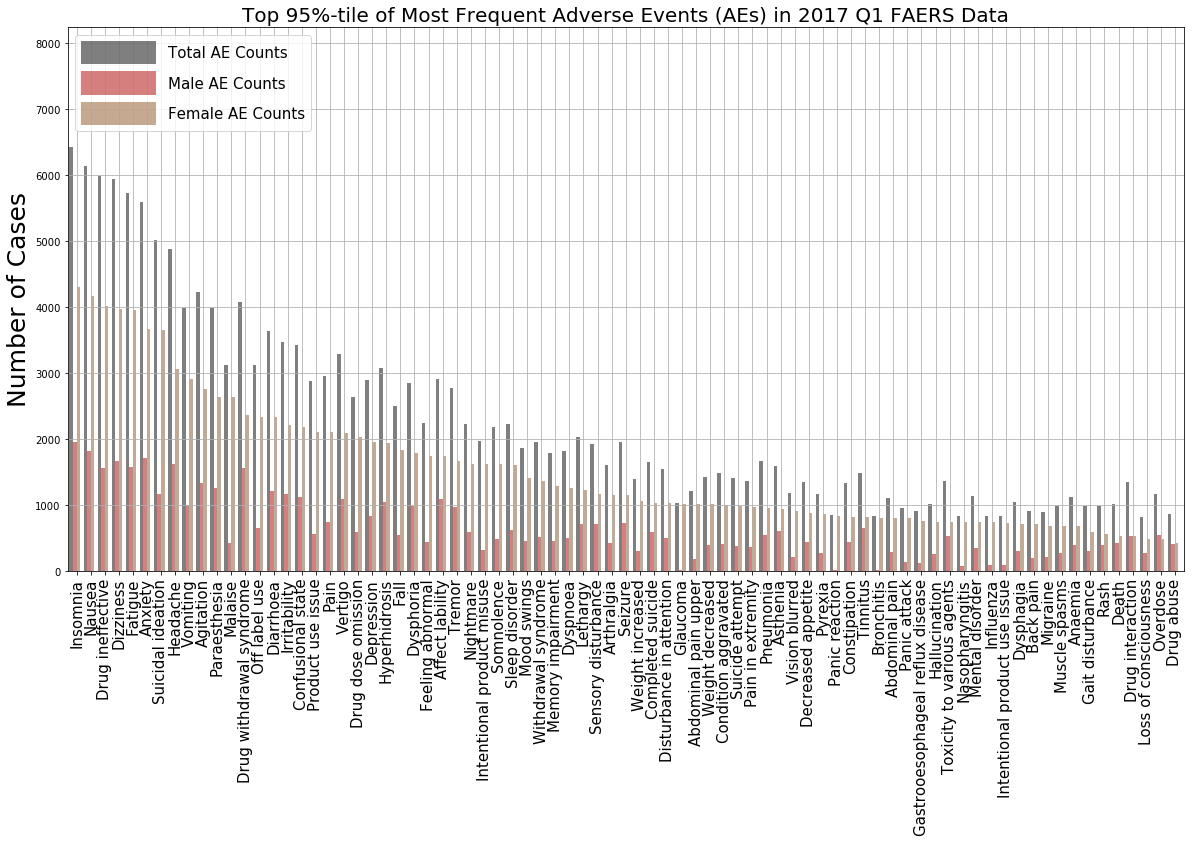

In [56]:
### Plot counts for top 99.9th%-tile of AEs in dataset across patient sex
# Setting up the positions and width for the bars
pos = list(range(len(All_AEs_World1_quant_totalcts['MedDRA_reac_term'])))
width = 0.25

# Plotting the bars onto plot
fig, ax = plt.subplots(figsize=(20,10))

# Create a bar with Male+Female data,
# in position pos,
plt.bar(pos,
        #World1ing All_AEs_World1_quant_totalcts['MedDRA_reac_term'] data,
        All_AEs_World1_quant_totalcts['MedDRA_reac_term'],
        # of width
        width,
        # with alpha 0.5
        alpha=0.5,
        # with color
        color="#000000",
        # with label the first value in first_name
        label='Total AE Counts')

# Create a bar with male AE data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos],
        #World1ing test1AEvalM_count['MedDRA_reac_term_M'] data,
        All_AEs_World1_quant_totalcts['MedDRA_reac_term_M'],
        # of width
        width,
        # with alpha 0.5
        alpha=0.5,
        # with color
        color="#ae0001",
        # with label the second value in first_name
        label= 'Male AE Counts')

# Create a bar with female data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos],
        #World1ing test1AEvalF_count['MedDRA_reac_term_F'] data,
        All_AEs_World1_quant_totalcts['MedDRA_reac_term_F'],
        # of width
        width,
        # with alpha 0.5
        alpha=0.5,
        # with color
        color="#8d5524",
        # with label the third value in first_name
        label='Female AE Counts')

# Set the y axis label
ax.set_ylabel('Number of Cases', fontsize = 25)

# Set the chart's title
ax.set_title('Top 95%-tile of Most Frequent Adverse Events (AEs) in 2017 Q1 FAERS Data', fontsize = 20)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(All_AEs_World1_quant_totalcts.index, rotation = 'vertical', fontsize = 15)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max((All_AEs_World1_quant_totalcts['MedDRA_reac_term'] + 
                 All_AEs_World1_quant_totalcts['MedDRA_reac_term_M'] + 
                 All_AEs_World1_quant_totalcts['MedDRA_reac_term_F'])*.65)] )

# Adding the legend and showing the plot
plt.legend(['Total AE Counts', 'Male AE Counts', 'Female AE Counts'], loc='upper left', 
           fontsize = 15, handlelength = 5, handleheight = 2)
plt.grid()
plt.show()